<p style="align: center;"></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>







---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>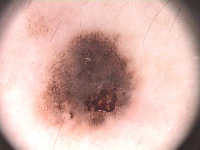</td><td>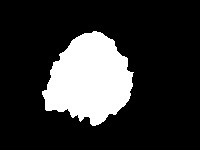</td></tr></table>

2. Разархивируем .rar файл.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2024-04-15 16:05:05--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2024-04-15 16:05:06--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc12d2eb0497fcd3f92e779d830e.dl.dropboxusercontent.com/cd/0/inline/CRHaAc9-YgX8HabLwlYtTHH2NYxdVxVyHeacvuHMJDpJcI1icOmc61Zv1dP1Q80VfdnBpOaeC_evLKC-i1fWZgoYXK0_QXBXhisQ2zAhaZ1r3YF8NMFKf69iojxAwbTqQZg/file# [following]
--2024-04-15 16:05:07--  https://uc12d2eb0497fcd3f92e779d830e.dl.dropboxusercontent.com/cd/0/inline/CRHaAc9-YgX8HabLwlYtTHH2NYxdVxVyHeacvuHMJDpJcI1icOmc61Zv1dP1Q80VfdnBpOaeC_evLKC-i1fWZgoYXK0_QXBXhisQ2zAhaZ1r3YF8NMFKf

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

Импортируем библиотеки, которые будем использовать в работе

In [ ]:
# для загрузки и обработки изображений
from skimage.io import imread
from skimage.transform import resize
import os
# работа с таблицами
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

from time import time



In [ ]:
images = []
lesions = []
root = '/kaggle/input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

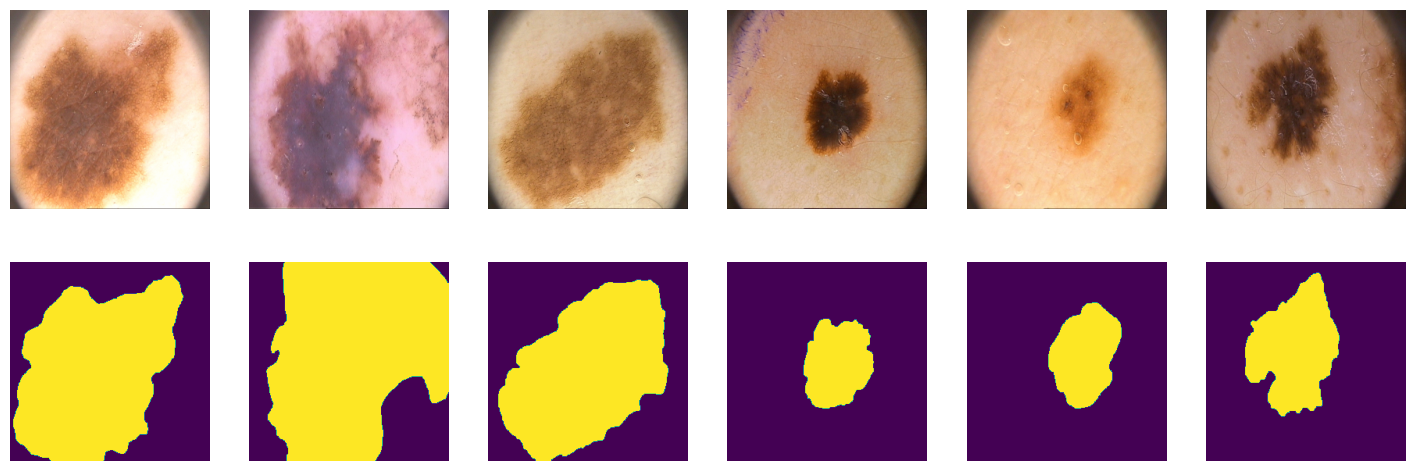

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

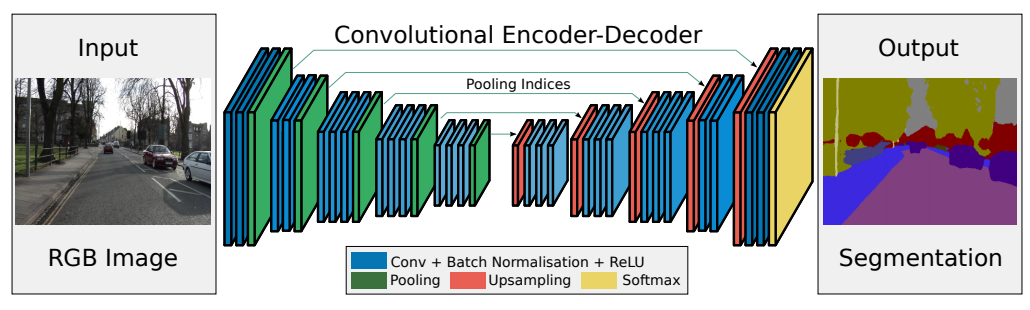

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

        )
        self.pool0 =  nn.MaxPool2d((2, 2)) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

        )
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()

        )
        self.pool3 =nn.MaxPool2d((2, 2))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 =  nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 =  nn.Upsample(scale_factor=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 =  nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        #print("e0:", e0.size())
        e1 = self.pool1(self.enc_conv1(e0))
        #print("e1:", e1.size())
        e2 = self.pool2(self.enc_conv2(e1))
        #print("e2:", e2.size())
        e3 = self.pool3(self.enc_conv3(e2))
        #print("e3:", e3.size())

        # bottleneck
        b =self.bottleneck_conv(e3)
        #print("b0:", b.size())

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        #print("d0:", d0.size())
        d1 = self.dec_conv1(self.upsample1(d0))
        #print("d1:", d1.size())
        d2 = self.dec_conv2(self.upsample2(d1))
        #print("d2:", d2.size())
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W

    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь 

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

def bce_loss(y_real, y_pred):
    input = torch.sigmoid(y_pred)
    loss = F.binary_cross_entropy(input, y_real)
    return loss
    # TODO
    # please don't use nn.BCELoss. write it from scratch

In [ ]:
def bce_loss(y_real, y_pred):
    return (torch.max(y_pred, torch.zeros(y_pred.shape, device = device))
            - y_real*y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(name, model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    best_score= 0
    best_epoch = 0
    train_loss = []
    val_loss = []
    score = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):

        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            # set parameter gradients to zero
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)

        train_loss.append(avg_loss.detach().cpu())
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_pred = model(X_val.to(device))
            X_val = X_val.detach().cpu()
            Y_hat = Y_pred.detach().cpu()
            Y_val = Y_val.to(device)
            loss_val = loss_fn(Y_val, Y_pred)
            Y_hat = torch.sigmoid(Y_hat)
            val_loss.append(loss_val.detach().cpu()/len(data_val))
            Y_val = Y_val.detach().cpu()
            if val_loss[-1] <= valid_loss_min:
                torch.save(model.state_dict(), f"{name}.pt")
                valid_loss_min = val_loss[-1]
        # Visualize tools
        score.append(score_model(model, iou_pytorch, data_val))

        if score[-1] > best_score:
            best_score = score[-1]
            best_epoch = epoch
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')


        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    print(f"Best score: {best_score}")
    print(f"Best epoch: {best_epoch}")
    return train_loss, val_loss, score

Напишем функцию, которая будет выводит графики тренировки и результата нашей модели

In [ ]:
def plot_training(train_loss, val_loss, score,name):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.title(f"{name} loss")
    plt.xlabel("epoch")
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="valid_loss")
    plt.legend()
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title(f"{name} score")
    plt.xlabel("epoch")
    plt.plot(score, label="valid score")
    plt.legend()
    plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_batch in data:
            Y_pred = model(X_batch.to(device))
            Y_pred = Y_pred.detach().cpu()
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)
            scores += metric(Y_pred, Y_batch).mean().item()
    return scores/len(data)

Создадим таблицу `training_results`, в которую будем заносить результаты обучения моделей

In [ ]:
training_results = pd.DataFrame(columns=['model', 'loss', 'iou_test_score'])

Напишем функцию, которая будет обучать модель и выводить полученные результаты

In [ ]:
def training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name):
    global training_results
    name = f"{model_name}_{loss_name}"
    optim = torch.optim.Adam(model.parameters())
    result = train(name, model, optim, metric, max_epochs, data_tr, data_val)
    plot_training(*result, name)
    model.load_state_dict(torch.load(f'{name}.pt'))
    score = score_model(model, iou_pytorch, data_val)
    print(f"best score {score}")
    training_results.loc[ len(training_results.index )] = [model_name, loss_name, score]
    return result, name

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


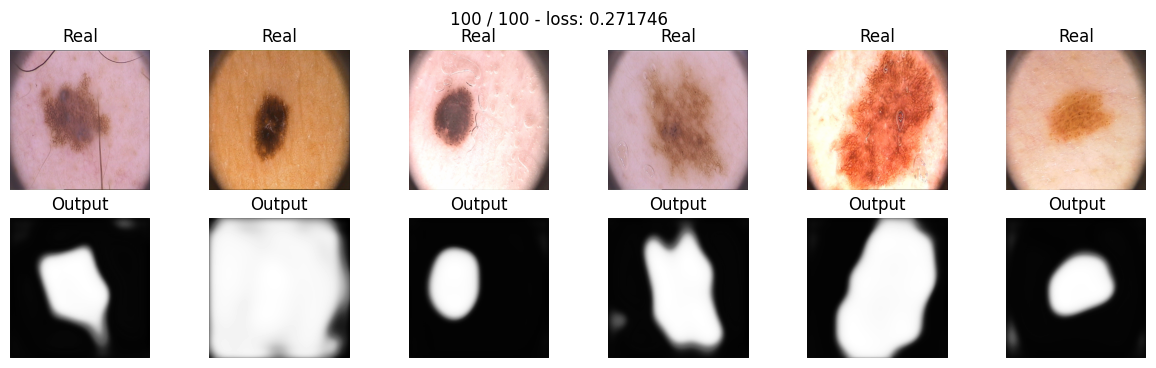

Best score: 0.7099999785423279
Best epoch: 93


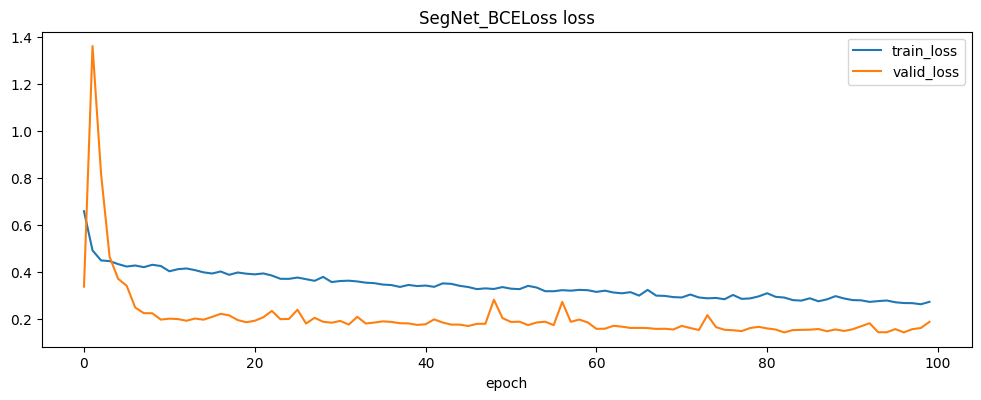

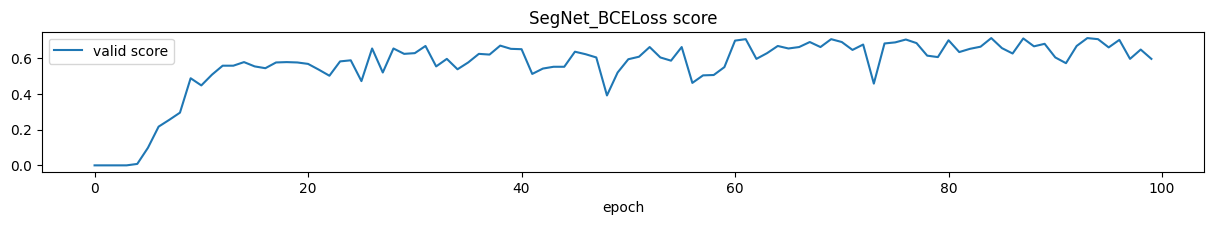

best score 0.6499999761581421


In [ ]:
model = SegNet().to(device)
max_epochs = 100
metric = bce_loss
model_name = "SegNet"
loss_name = "BCELoss"

optim = torch.optim.Adam(model.parameters())
segnet_bce = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, smooth = 1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    num = torch.sum(2* y_real * y_pred)
    den =  torch.sum(y_real + y_pred)
    res = 1 - (num+smooth)/(den+smooth)
    return res


Проводим тестирование:

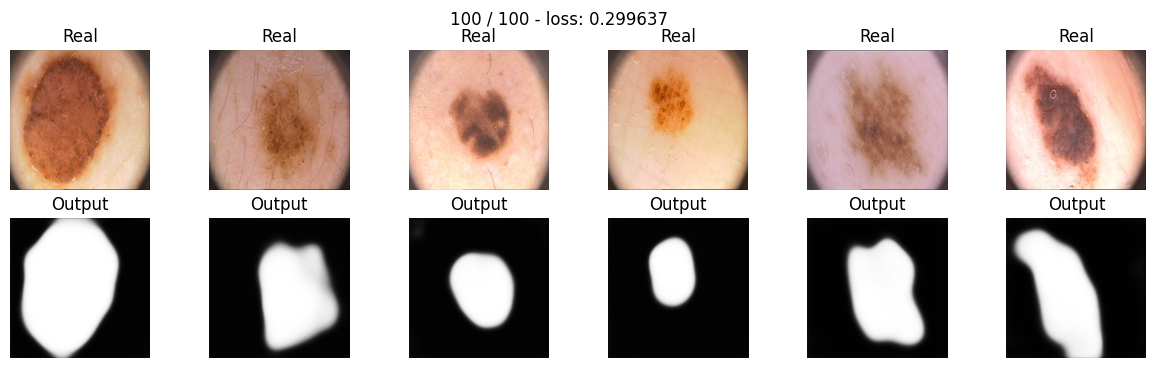

Best score: 0.7059999704360962
Best epoch: 96


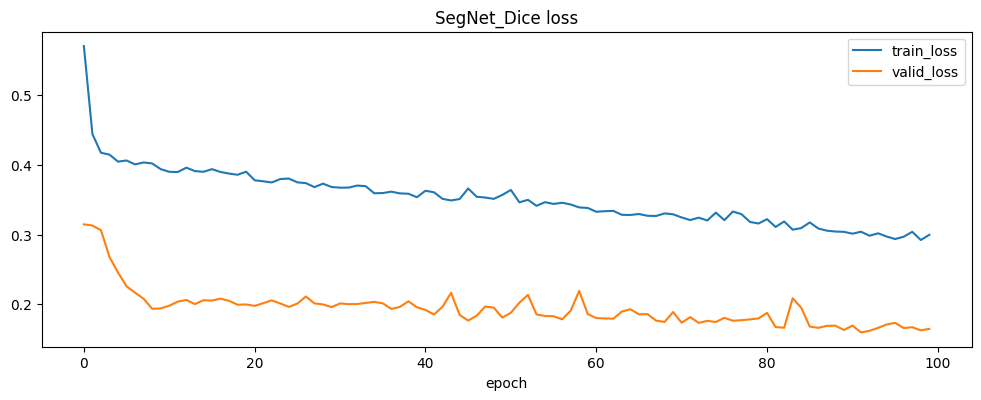

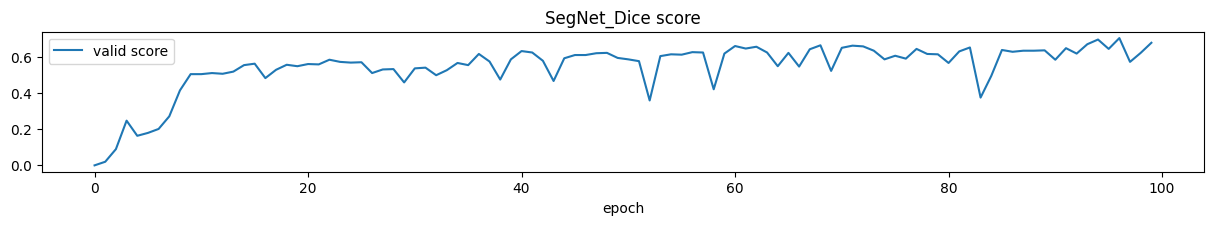

best score 0.6499999463558197


In [ ]:
model = SegNet().to(device)
max_epochs = 100
metric = dice_loss
model_name = "SegNet"
loss_name = "Dice"
optim = torch.optim.Adam(model.parameters())
segnet_dice = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    y_real = torch.unsqueeze(y_real, 1)
    y_pred = torch.clamp(torch.sigmoid(torch.unsqueeze(y_pred, 1)), eps, 1)
    result = ((1 - y_pred) ** gamma) * y_real * torch.log(y_pred) + \
              (1 - y_real) * torch.log(1 - y_pred)
    return -torch.mean(result)



In [ ]:
# протестируем функцию
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

focal_loss(y_r, y_p)

tensor(0.4215)

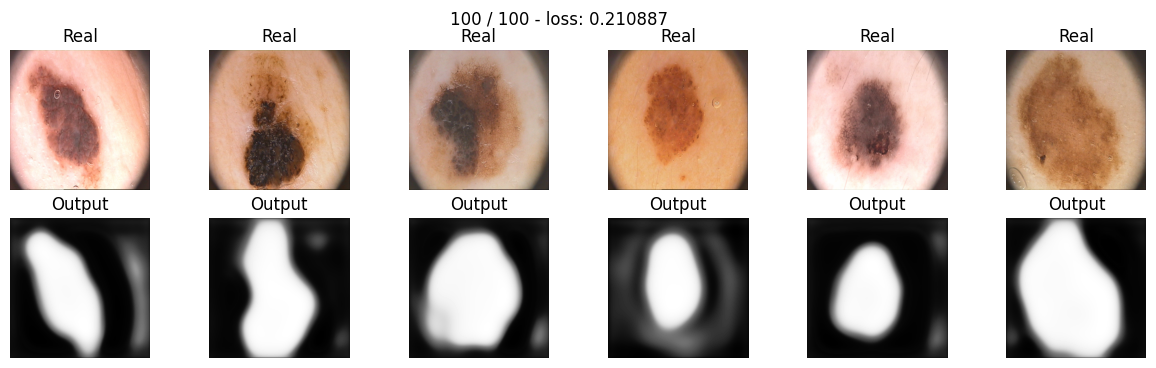

Best score: 0.7520000040531158
Best epoch: 93


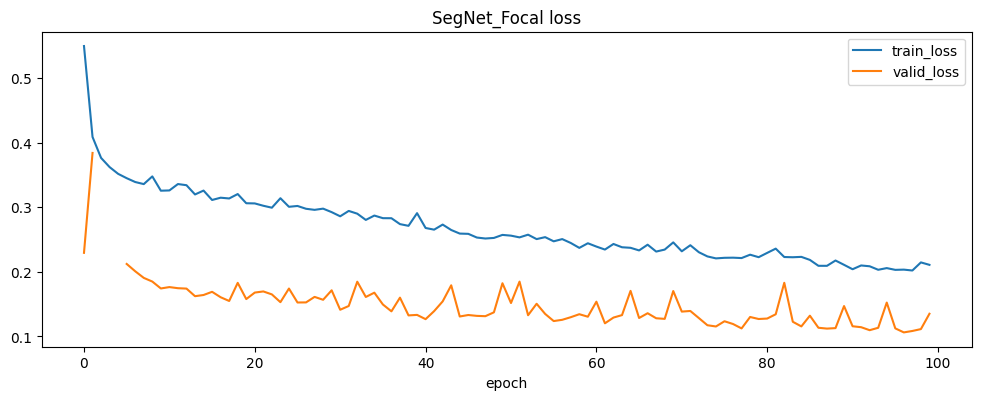

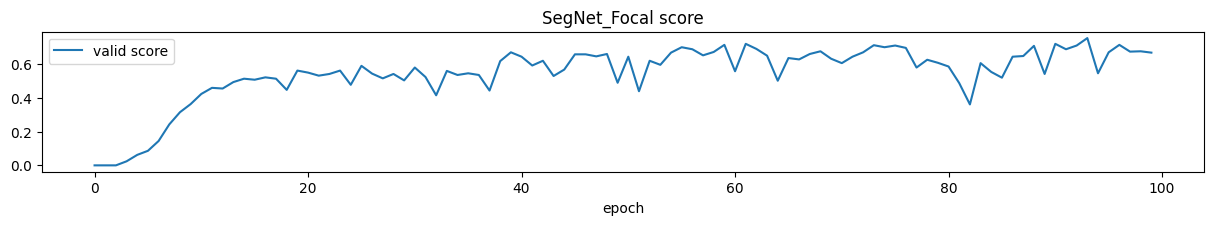

best score 0.7119999825954437


In [ ]:
model = SegNet().to(device)
max_epochs = 100
metric = focal_loss
model_name = "SegNet"
loss_name = "Focal"
optim = torch.optim.Adam(model.parameters())
segnet_focal = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов 

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Boundry Loss**

`Boundary loss (BL)` - это функция потерь, которая используется в задачах сегментации изображений для улучшения обнаружения границ объектов. Основная идея `Boundary loss` заключается в том, чтобы сосредоточиться на точности предсказания границ между объектами на изображении.

Когда мы говорим о сегментации изображений, границы объектов играют важную роль, поскольку они определяют границы между различными объектами на изображении. Поэтому важно, чтобы модель точно определяла эти границы. BL помогает модели сосредоточиться именно на этом аспекте предсказания.

Основные преимущества `Boundary Loss`:

 - Улучшение точности границ: BL помогает модели сосредоточиться на точном обнаружении границ между объектами, что важно для многих приложений в области компьютерного зрения, таких как обнаружение объектов и сегментация.

 - Повышение качества сегментации: Поскольку BL придает больший вес предсказанным границам, его использование может улучшить качество сегментации объектов на изображении.

 - Стабильность обучения: BL может помочь стабилизировать процесс обучения модели сегментации, особенно если модель имеет тенденцию к недообучению или переобучению.

`Boundary Loss` вычисляется следующим образом: вычисляется разница между y_real и y_pred, а затем применяется операция свертки с ядром размером 3x3, содержащим единицы, для выделения границ. Затем возвращается среднее абсолютное значение этой разницы, что и является `Boundary Loss`.


In [ ]:
def boundary_loss(y_real, y_pred):
    diff = torch.abs(torch.nn.functional.conv2d(y_real - y_pred, torch.ones(1, 1, 3, 3).to(y_real.device), padding=1))
    return torch.mean(diff)

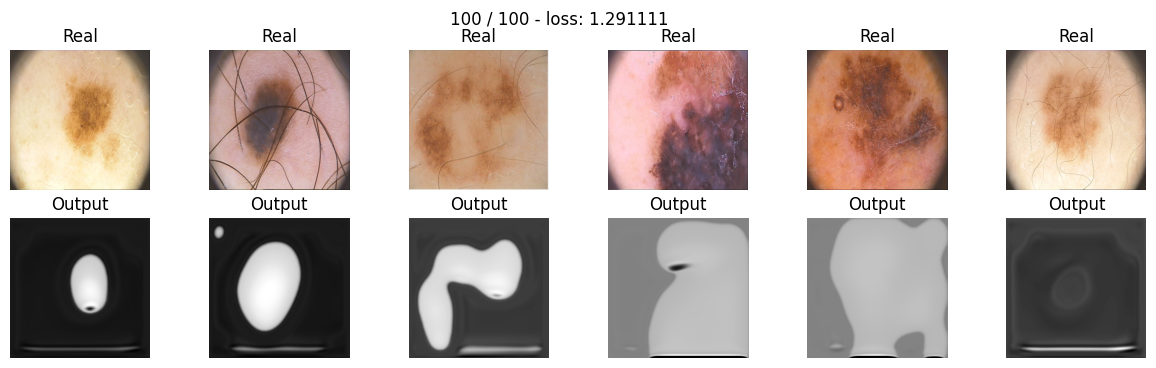

Best score: 0.5919999778270721
Best epoch: 72


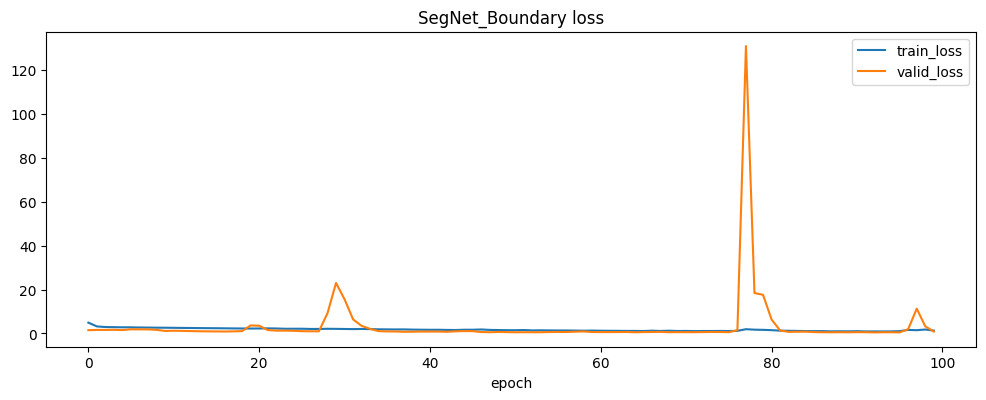

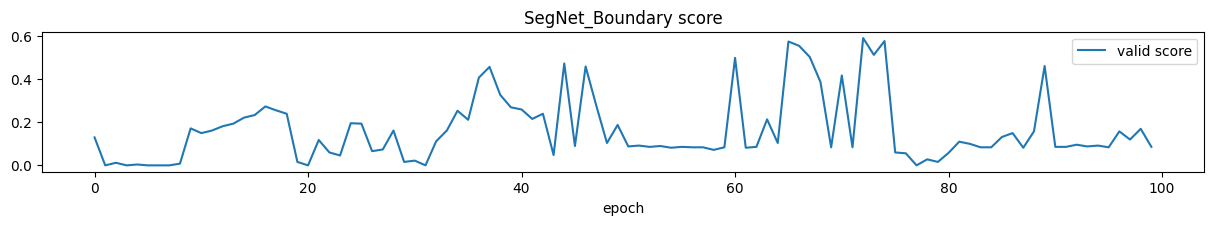

best score 0.09599999710917473


In [ ]:
model = SegNet().to(device)
max_epochs = 100
metric = boundary_loss
model_name = "SegNet"
loss_name = "Boundary"
optim = torch.optim.Adam(model.parameters())
segnet_boundary = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

Мы видим, что функция потерь на наших данных очень нестабильна и дает неоднозначные результаты

-----------------------------------------------------------------------------------------

# U-Net 

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

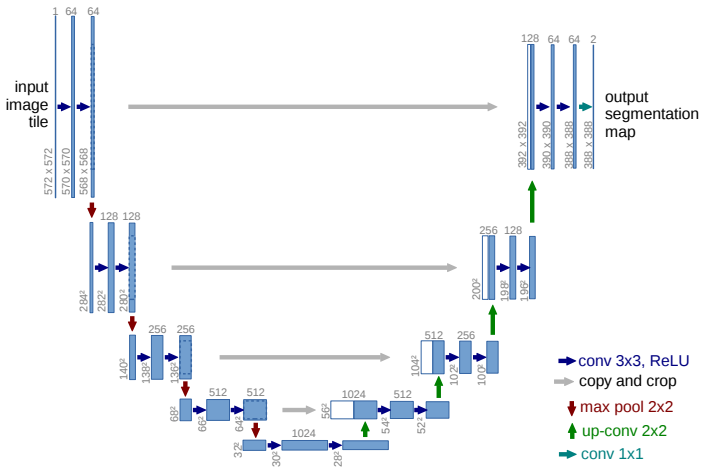

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),

        )
        self.pool0 =  nn.MaxPool2d((2, 2)) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),

        )
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()

        )
        self.pool3 =nn.MaxPool2d((2, 2))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512,1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        ) #nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 =  nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 =  nn.Upsample(scale_factor=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
             nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 =  nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e1 = self.enc_conv1(e1)
        e2 = self.pool1(e1)
        e2 = self.enc_conv2(e2)
        e3 = self.pool2(e2)
        e3 = self.enc_conv3(e3)
        b = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck_conv(b)

        # Decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))

        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2), dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0), dim=1)
        d3 = self.dec_conv3(d3)

        return self.outconv(d3)

**BCEloss**

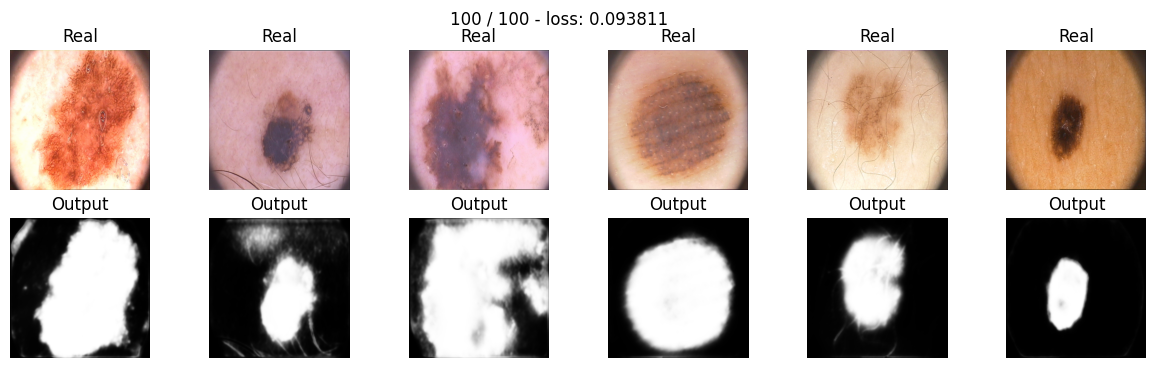

Best score: 0.7860000133514404
Best epoch: 93


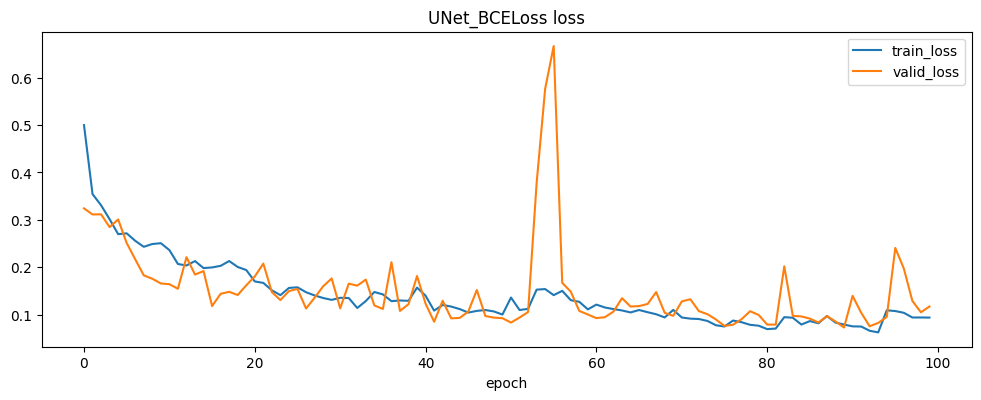

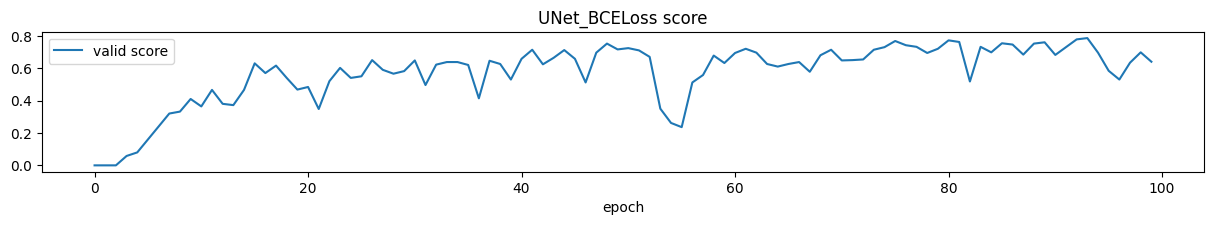

best score 0.7599999904632568


In [ ]:
model = UNet().to(device)
max_epochs = 100
metric = bce_loss
model_name = "UNet"
loss_name = "BCELoss"
optim = torch.optim.Adam(model.parameters())
unet_bce = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Dice Loss**

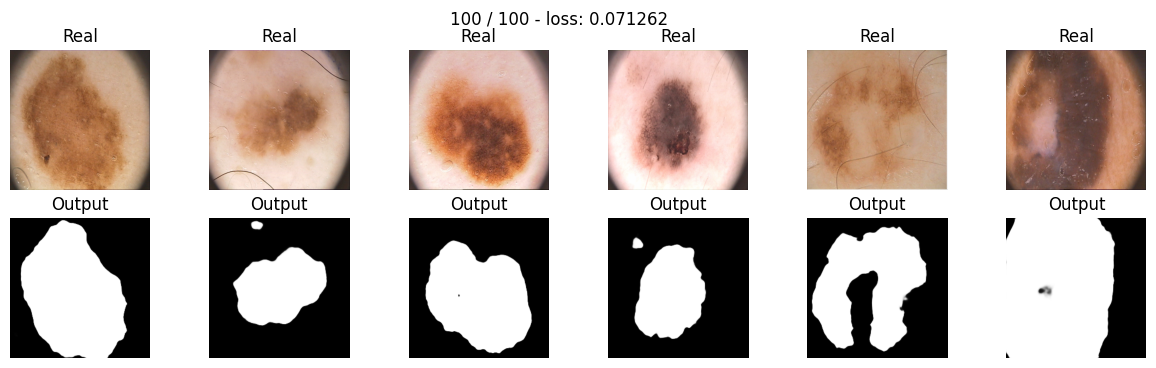

Best score: 0.7720000147819519
Best epoch: 93


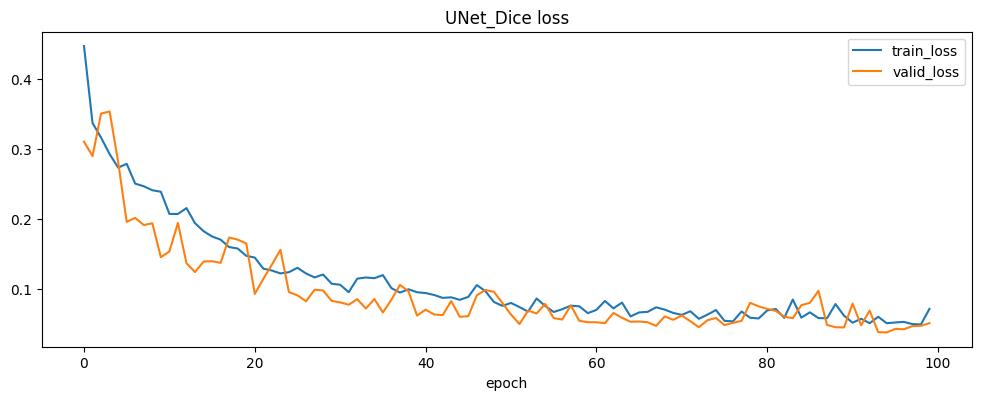

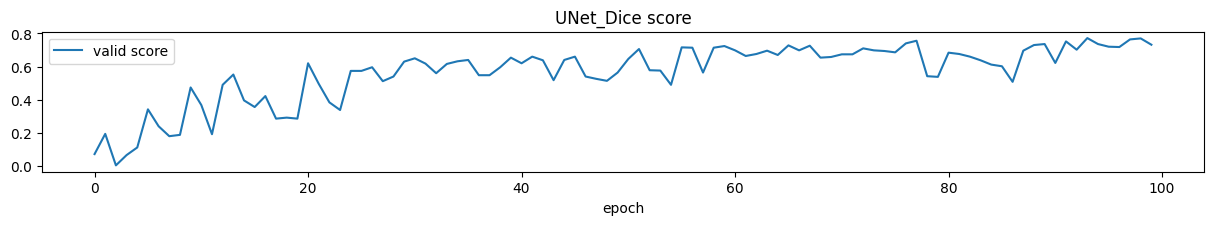

best score 0.7360000312328339


In [ ]:
model = UNet().to(device)
max_epochs = 100
metric = dice_loss
model_name = "UNet"
loss_name = "Dice"
optim = torch.optim.Adam(model.parameters())
unet_dice = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Focal Loss**

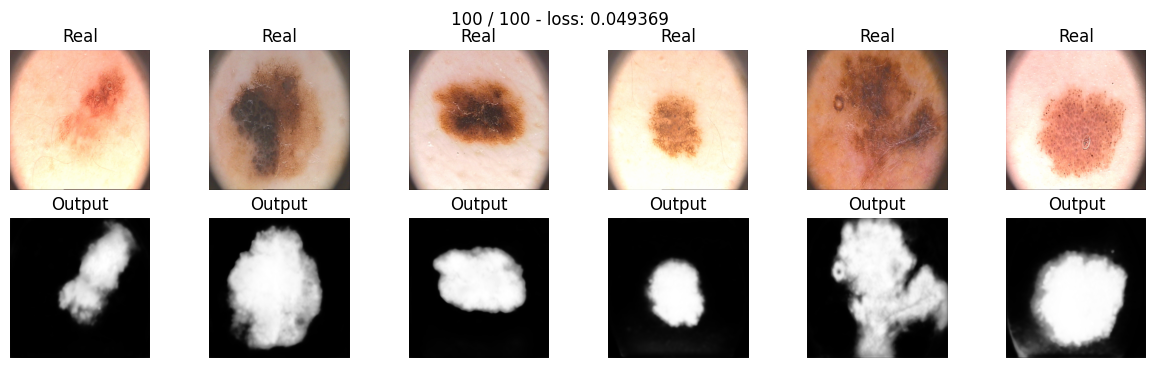

Best score: 0.7719999849796295
Best epoch: 73


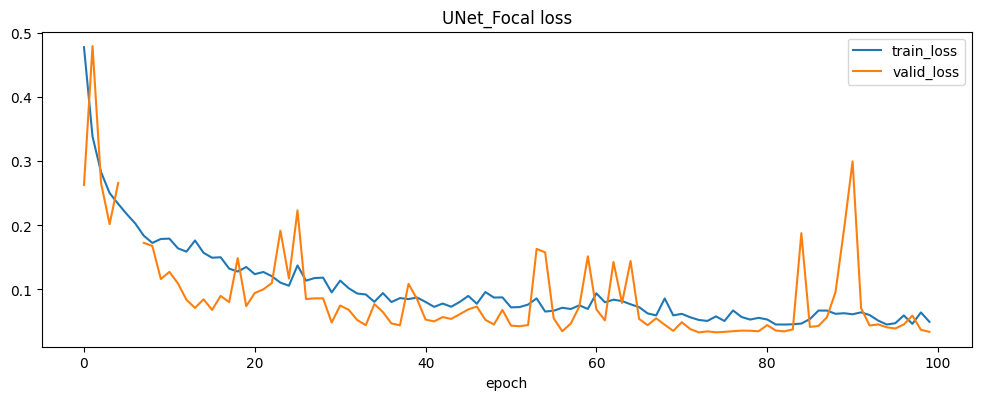

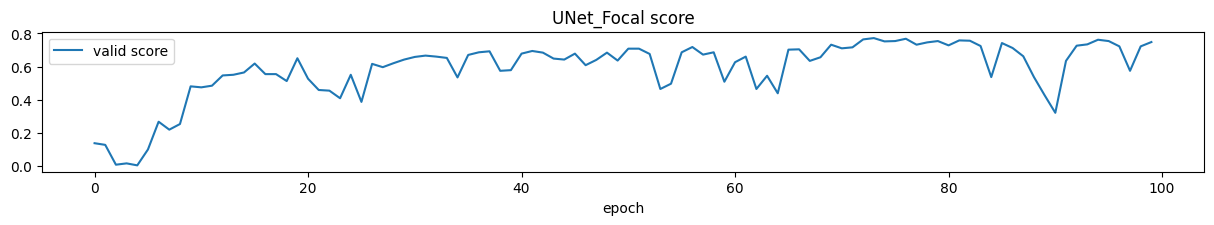

best score 0.7639999687671661


In [ ]:
model = UNet().to(device)
max_epochs = 100
metric = focal_loss
model_name = "UNet"
loss_name = "Focal"
optim = torch.optim.Adam(model.parameters())
unet_focal = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Boundary Loss**

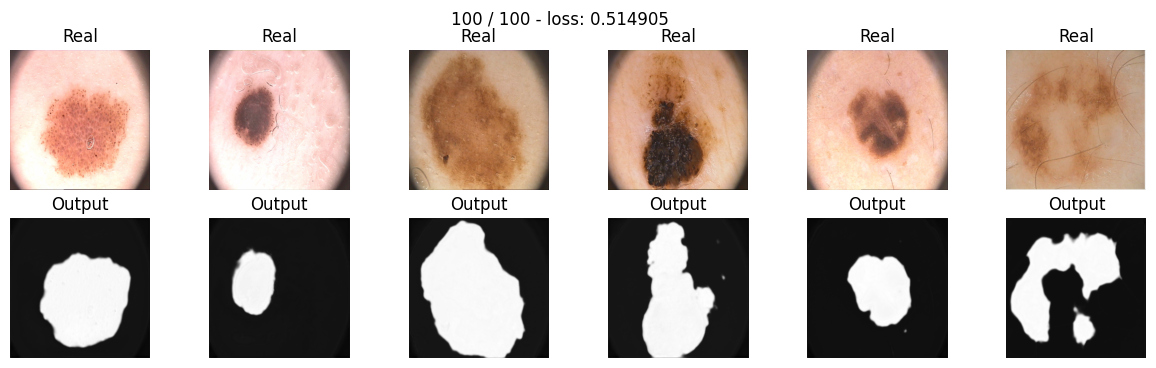

Best score: 0.7059999406337738
Best epoch: 99


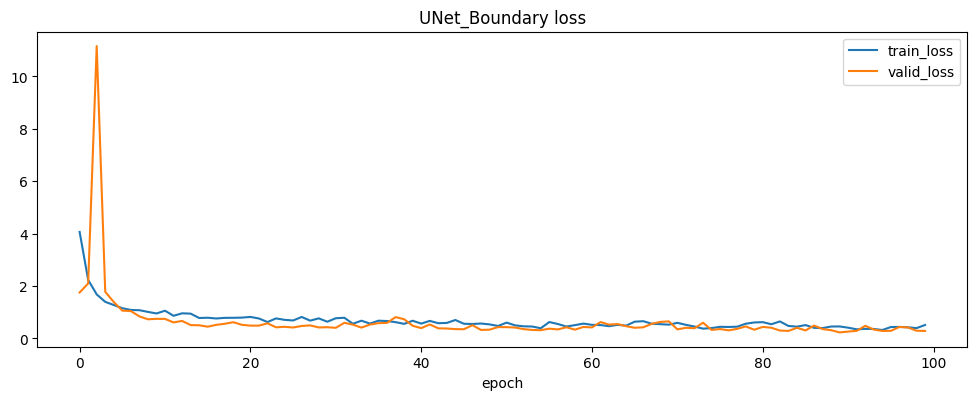

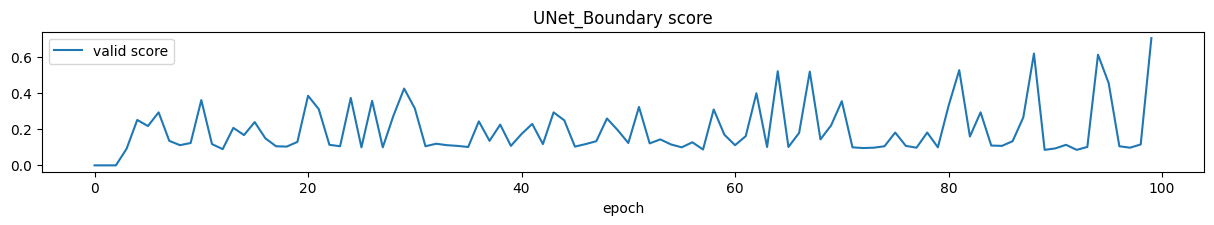

best score 0.0860000029206276


In [ ]:
model = UNet().to(device)
max_epochs = 100
metric = boundary_loss
model_name = "UNet"
loss_name = "Boundary"
optim = torch.optim.Adam(model.parameters())
unet_boundary = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

На лучших параметрах модель показывает очень плохой результат, при этом лучший результат модели на валидационной выборке довольно неплохой, вероятно это говорит о том, что модель быстро переобучается. Хотя визуально сегментация выглядит довольно неплохо

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 =nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 =  nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 =nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512,512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512,1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(512, 512,  kernel_size = 3, stride=2, padding=1, output_padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride=2, padding=1, output_padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=  3, stride=2, padding=1,output_padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 =  nn.ConvTranspose2d(64, 64, kernel_size =  3, stride=2, padding=1,output_padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.outconv = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))

        return self.outconv(d3)

**BCE Loss**

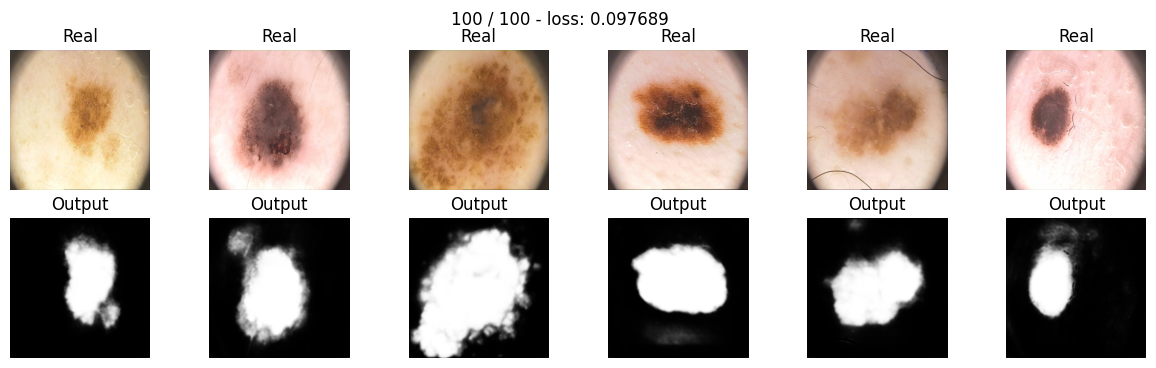

Best score: 0.7619999945163727
Best epoch: 74


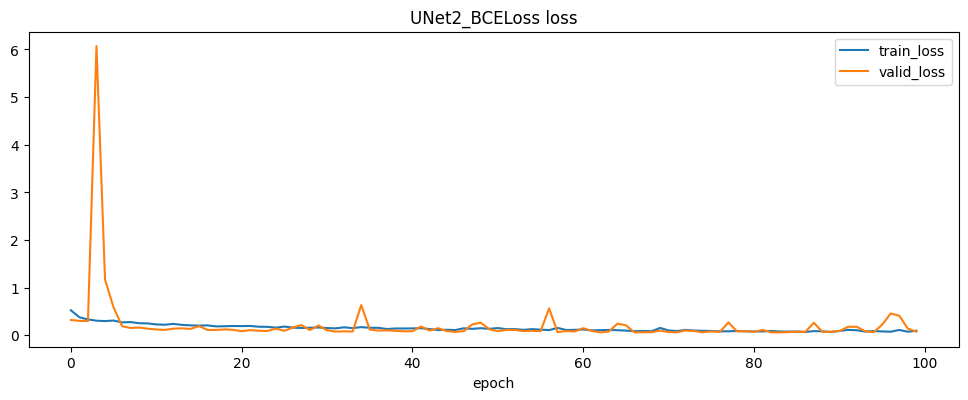

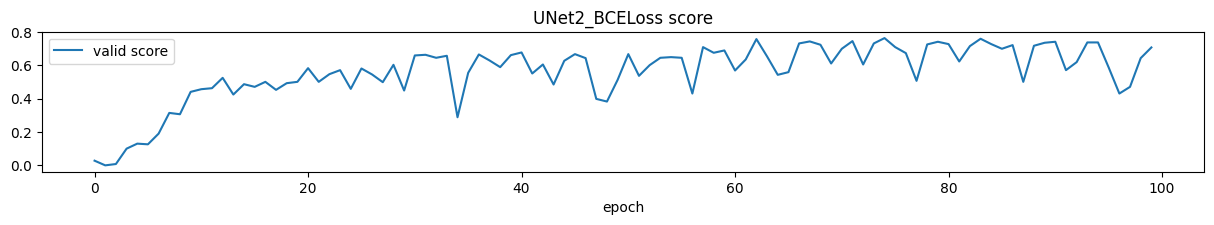

best score 0.7579999566078186


In [ ]:
model = UNet2().to(device)
max_epochs = 100
metric = bce_loss
model_name = "UNet2"
loss_name = "BCELoss"
optim = torch.optim.Adam(model.parameters())
unet2_bce = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Dice Loss**

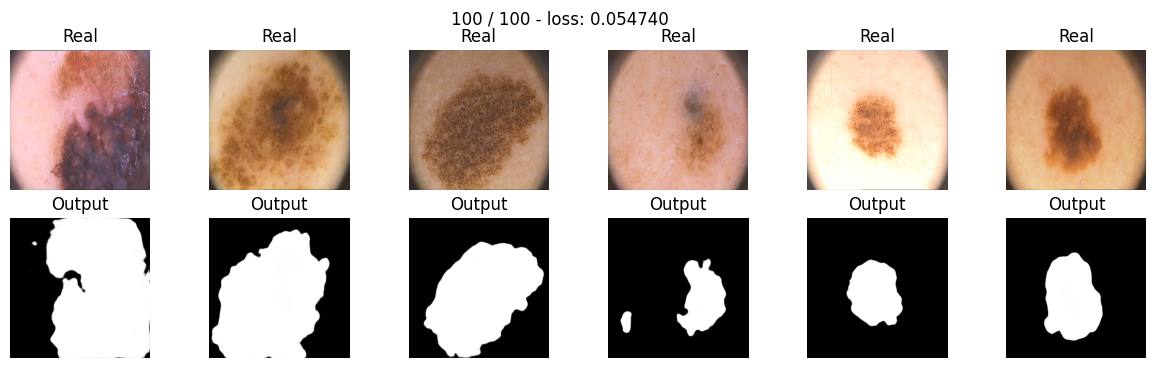

Best score: 0.7320000231266022
Best epoch: 96


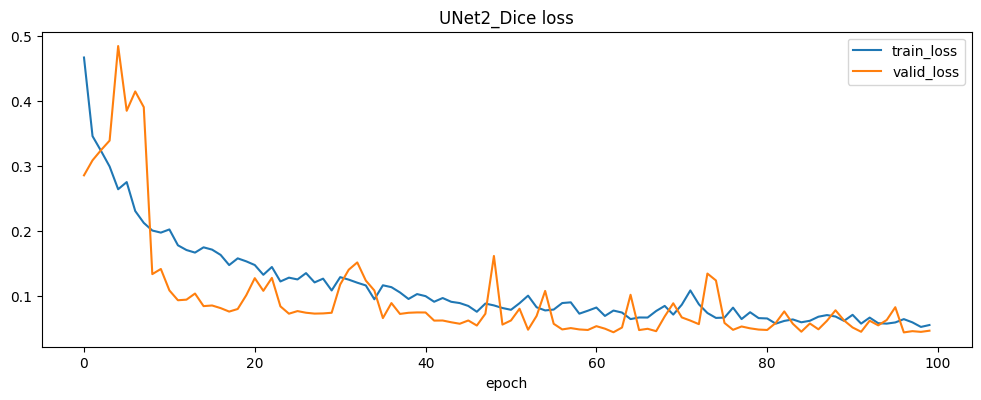

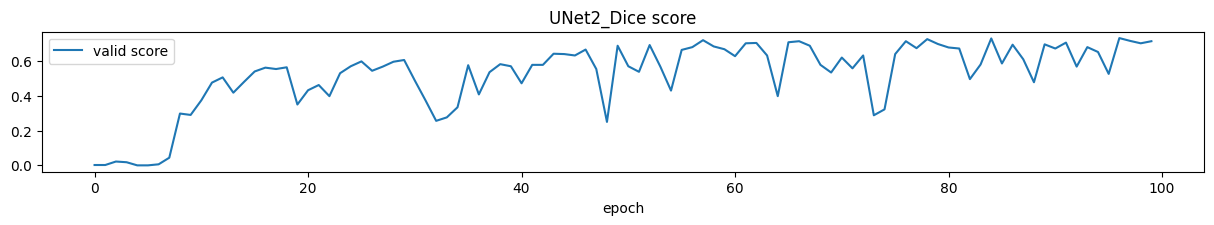

best score 0.7320000231266022


In [ ]:
model = UNet2().to(device)
max_epochs = 100
metric = dice_loss
model_name = "UNet2"
loss_name = "Dice"
optim = torch.optim.Adam(model.parameters())
unet2_dice = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Focal loss**

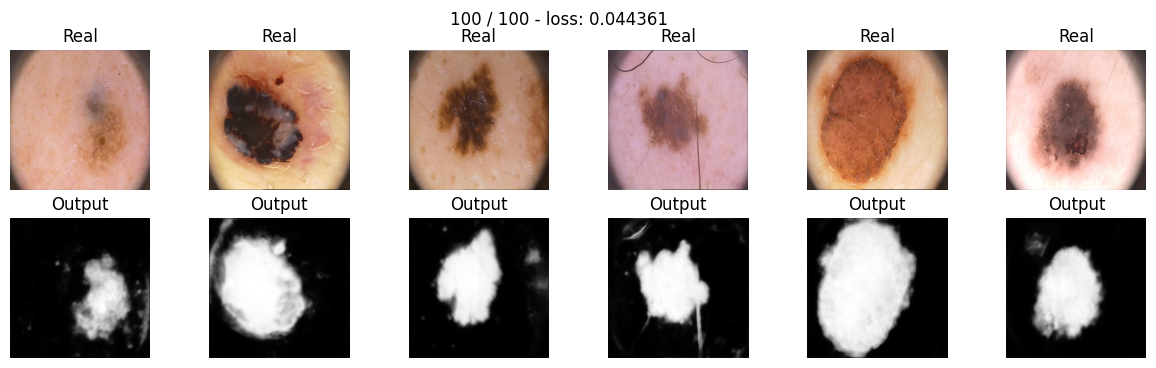

Best score: 0.7799999415874481
Best epoch: 96


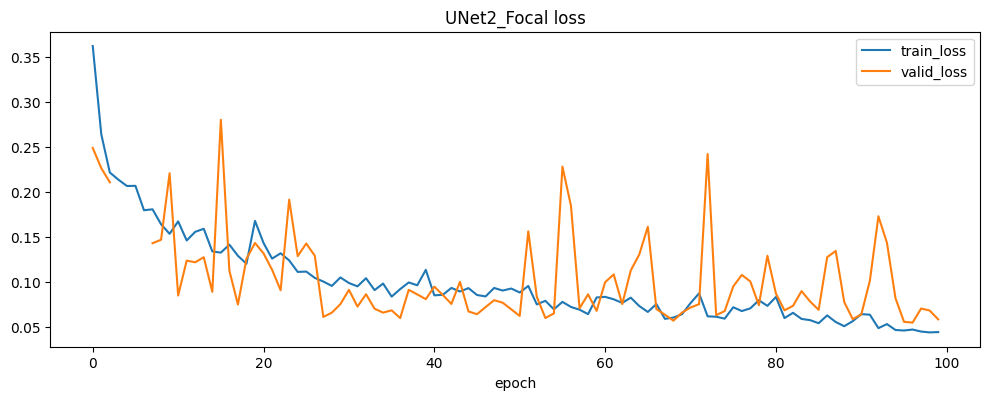

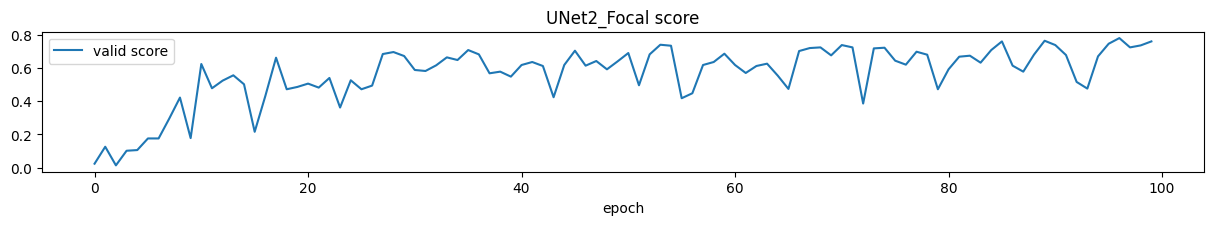

best score 0.7800000011920929


In [ ]:
model = UNet2().to(device)
max_epochs = 100
metric = focal_loss
model_name = "UNet2"
loss_name = "Focal"
optim = torch.optim.Adam(model.parameters())
unet2_focal = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

**Boundary Loss**

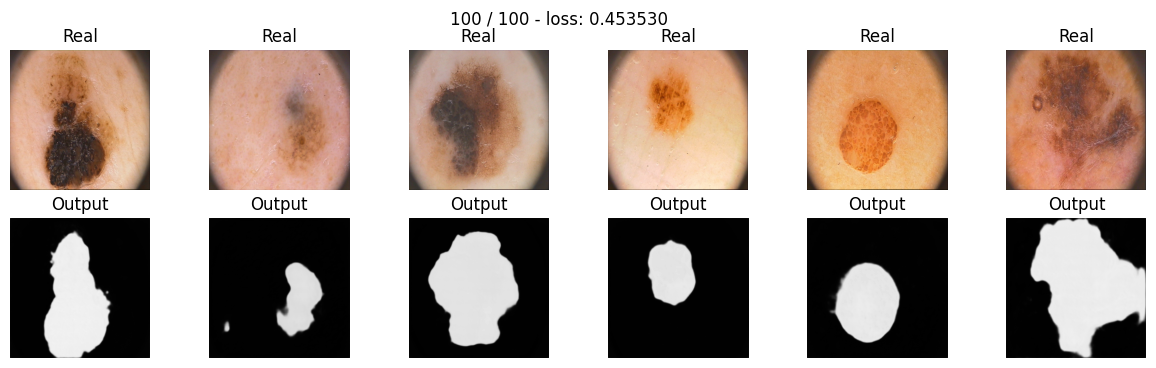

Best score: 0.6879999935626984
Best epoch: 99


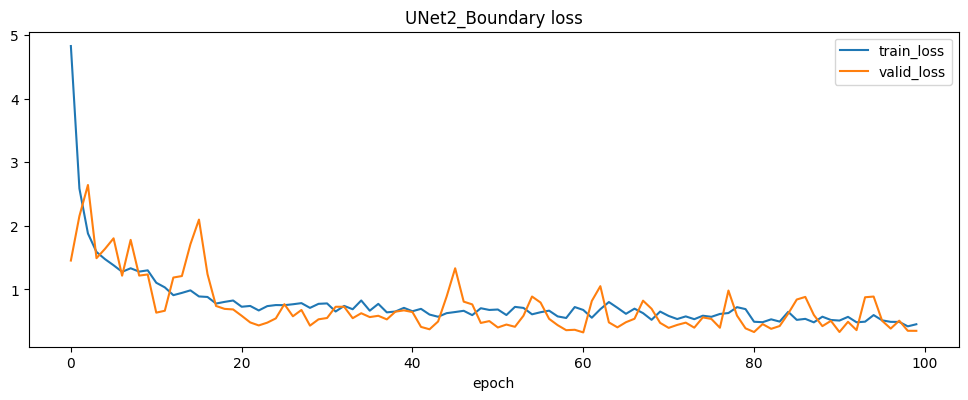

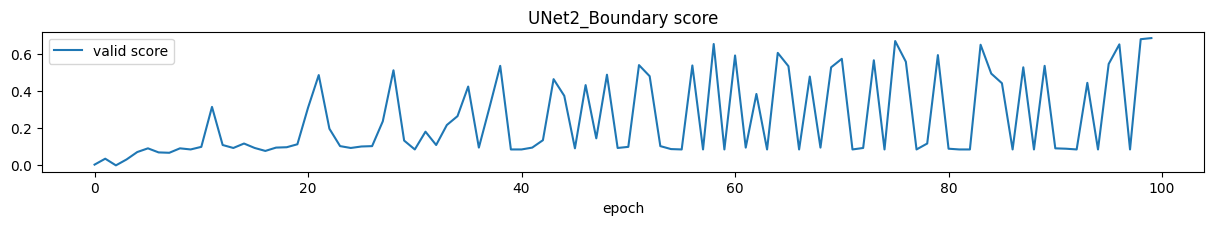

best score 0.593999981880188


In [ ]:
model = UNet2().to(device)
max_epochs = 100
metric = boundary_loss
model_name = "UNet2"
loss_name = "Boundary"
optim = torch.optim.Adam(model.parameters())
unet2_boundary = training_model(model, metric, data_tr, data_val, max_epochs, model_name, loss_name)

Теперь модель с использоваием функции потерь `Boundary loss` намного более стабильно, однако результат ниже, чем при использованиие других функций потерь

# Отчет
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Для каждой модели построим графики метрик качества, полученные с помочью разных лосс-функций

**SegNet model**

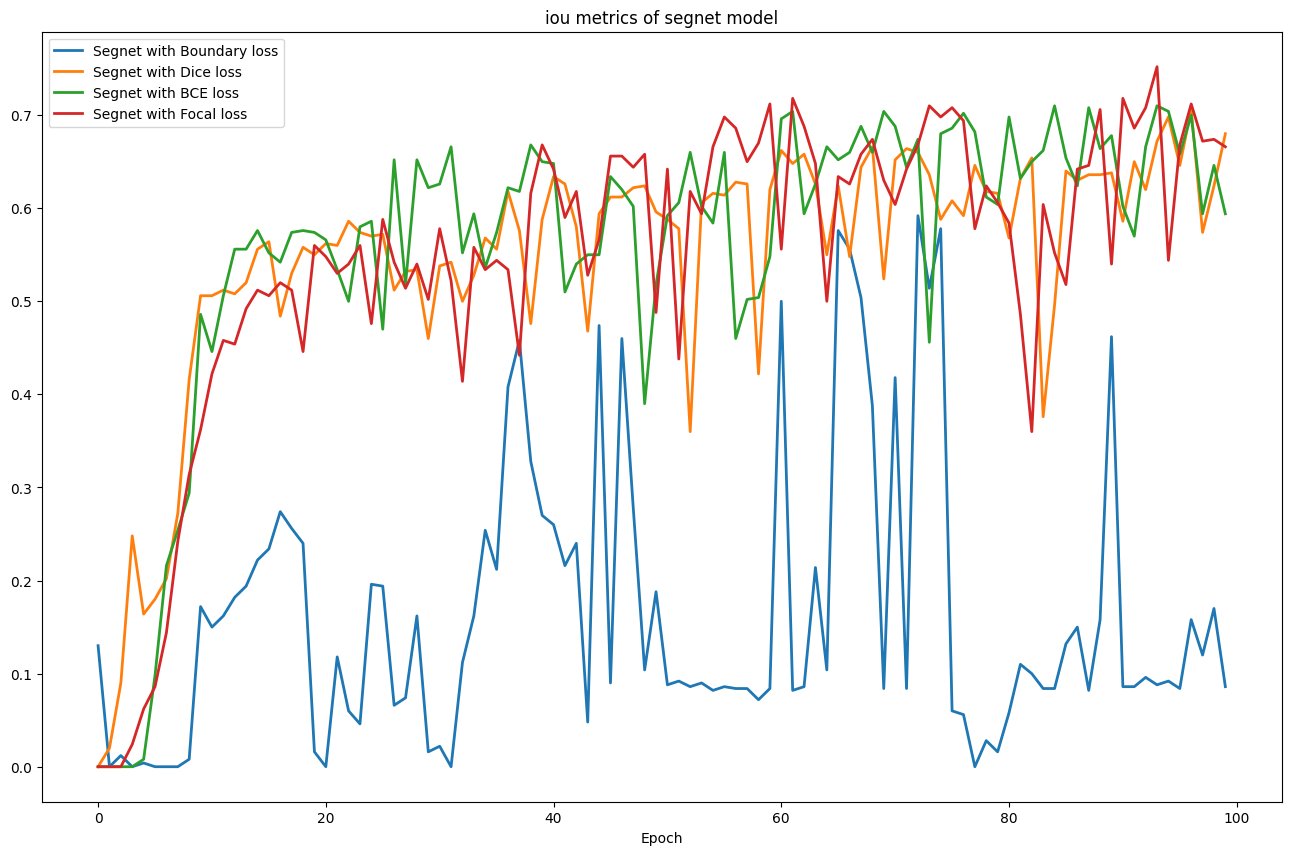

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of segnet model")
plt.plot(range(max_epochs), segnet_boundary[0][2], label="Segnet with Boundary loss", linewidth=2)
plt.plot(range(max_epochs), segnet_dice[0][2], label="Segnet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), segnet_bce[0][2], label="Segnet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), segnet_focal[0][2], label="Segnet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Unet model**

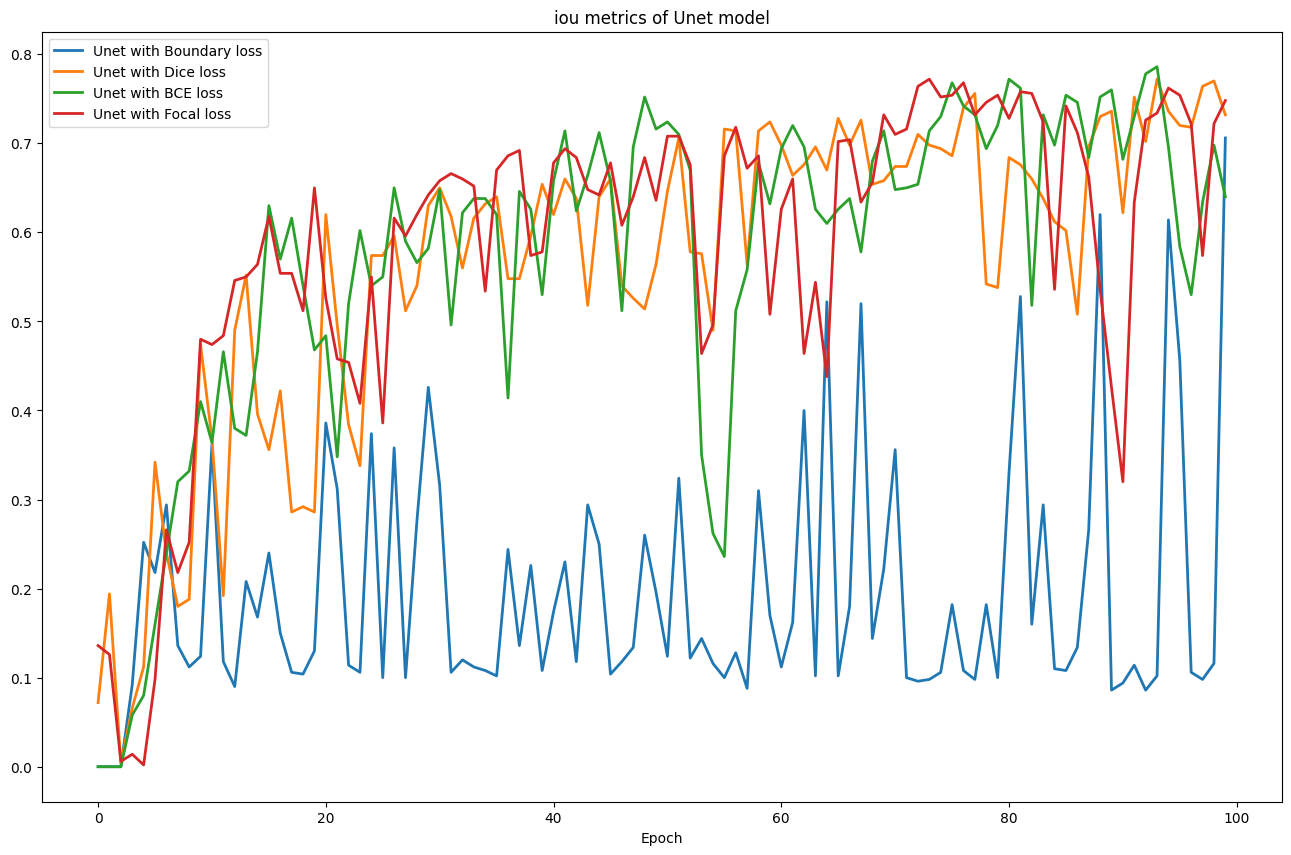

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of Unet model")
plt.plot(range(max_epochs), unet_boundary[0][2], label="Unet with Boundary loss", linewidth=2)
plt.plot(range(max_epochs), unet_dice[0][2], label="Unet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), unet_bce[0][2], label="Unet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), unet_focal[0][2], label="Unet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Unet2 model**

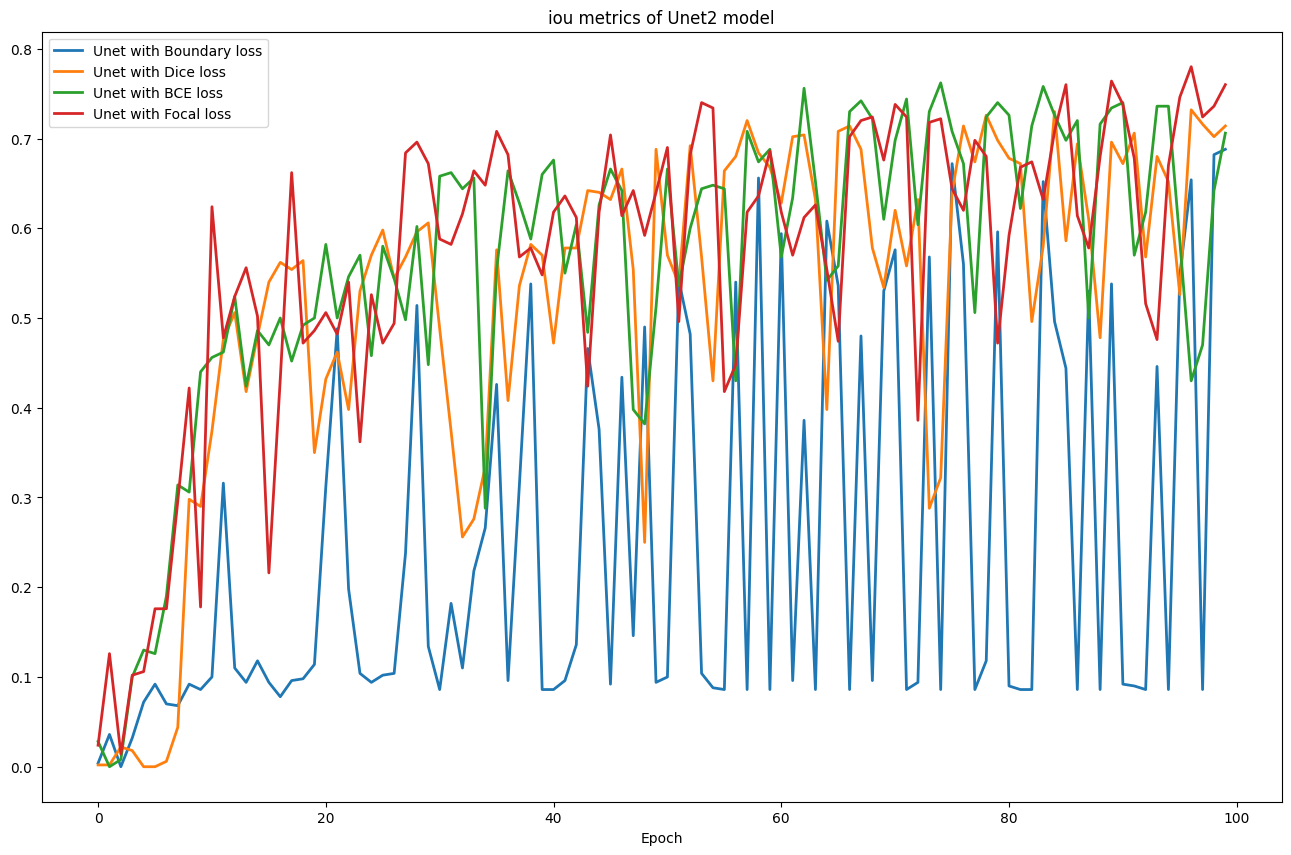

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of Unet2 model")
plt.plot(range(max_epochs), unet2_boundary[0][2], label="Unet with Boundary loss", linewidth=2)
plt.plot(range(max_epochs), unet2_dice[0][2], label="Unet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), unet2_bce[0][2], label="Unet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), unet2_focal[0][2], label="Unet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Мы видим, что обучение модели с использованием функции потерь `Boundary loss` не дает нужного результата. Возможно это происходит из-за того, что на картинках границы размыты, а `Boundary loss` помогает определить границы объектов сегментации

Посмотрим на общую таблицу

In [ ]:
pd.pivot_table(training_results, values='iou_test_score', index=['model', 'loss'])

iou_test_score
model  loss                    
SegNet BCELoss            0.650
       Boundary           0.096
       Dice               0.650
       Focal              0.712
UNet   BCELoss            0.760
       Boundary           0.086
       Dice               0.736
       Focal              0.764
UNet2  BCELoss            0.758
       Boundary           0.594
       Dice               0.732
       Focal              0.780

Напишем функцию ,которая выведет результаты на тестовой выборке моделей

In [ ]:
tests_results = pd.DataFrame(columns=['model', 'iou_score'])

In [ ]:
def predict(model, data, name, loss_fn):
    global tests_results
    X_test, Y_test = next(iter(data))
    model.load_state_dict(torch.load(f'{name}.pt'))
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = model(X_test.to(device))
        X_test = X_test.detach().cpu()
        Y_hat = Y_pred.detach().cpu()
        Y_test = Y_test.to(device)
        loss_val = loss_fn(Y_test, Y_pred)
        Y_hat = torch.sigmoid(Y_hat)
        Y_test = Y_test.detach().cpu()
        score = score_model(model, iou_pytorch, data)
        tests_results.loc[ len(tests_results.index )] = [name, score]
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(Y_test[k].numpy(), 0, 3), cmap='Reds')
            plt.title('Mask')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(torch.where(Y_hat[k, 0] > 0.5, 1,0), cmap='Reds')
            plt.title('Mask_test')
            plt.axis('off')
        plt.suptitle(f"model: {name}, score: {score}")
        plt.show()


Для теста предлагаю взять модели, которые показали значение `iou_score` > 0.7
выделим их в отдельный список

In [ ]:
models_for_test = [
    [SegNet().to(device), segnet_focal[1], focal_loss],
    [UNet().to(device), unet_bce[1], bce_loss],
    [UNet().to(device), unet_dice[1], dice_loss],
    [UNet().to(device), unet_focal[1], focal_loss],
    [UNet2().to(device), unet2_bce[1], bce_loss],
    [UNet2().to(device), unet2_dice[1], dice_loss],
    [UNet2().to(device), unet2_focal[1], focal_loss]]

Посотрим, что покажут модели на тестовой выборке

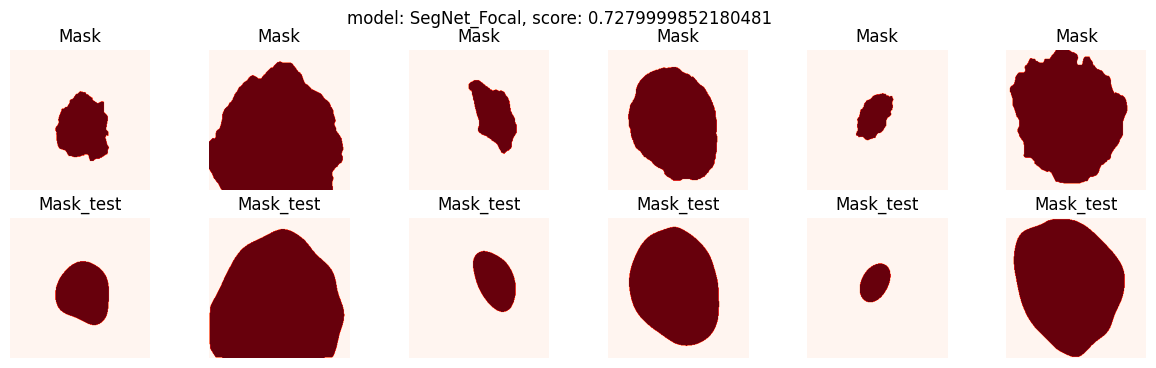

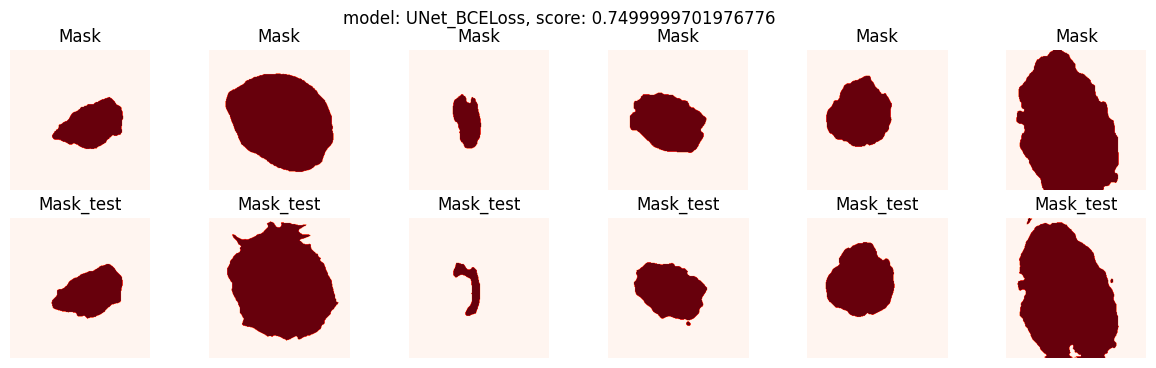

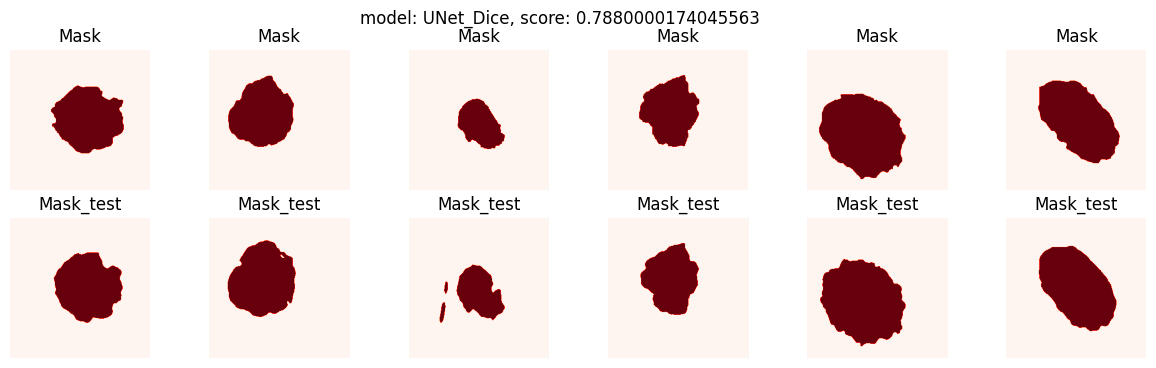

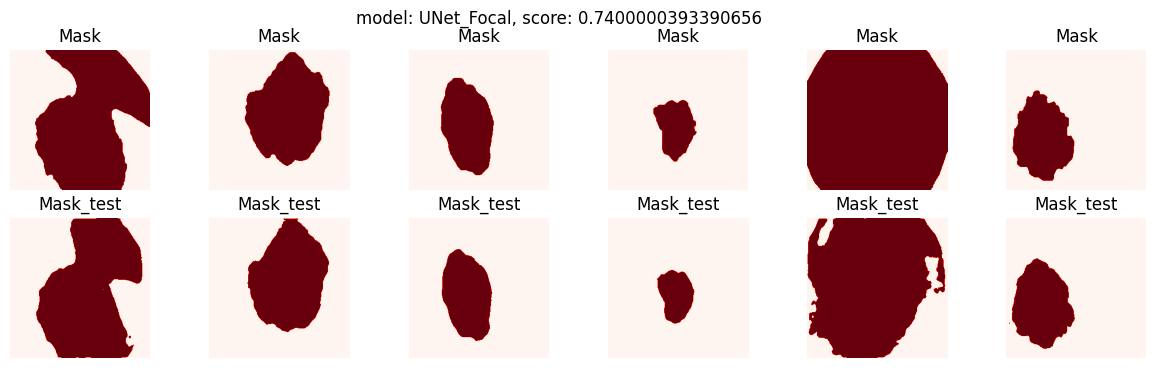

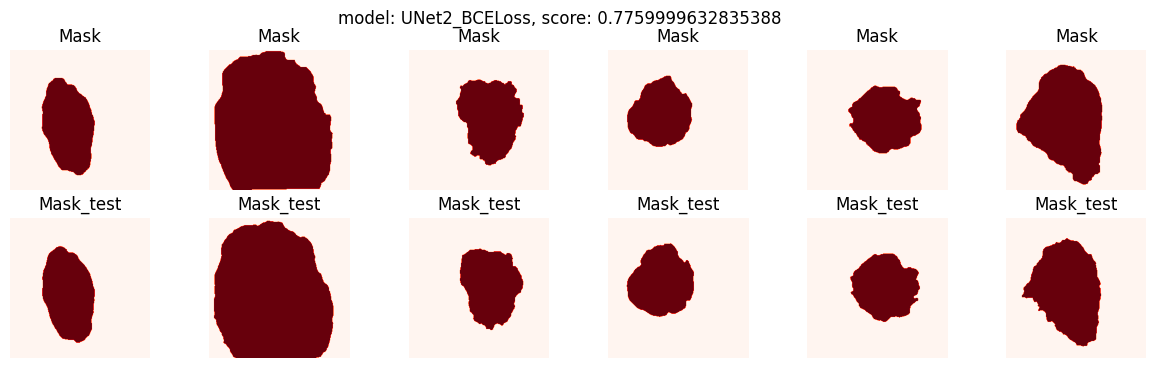

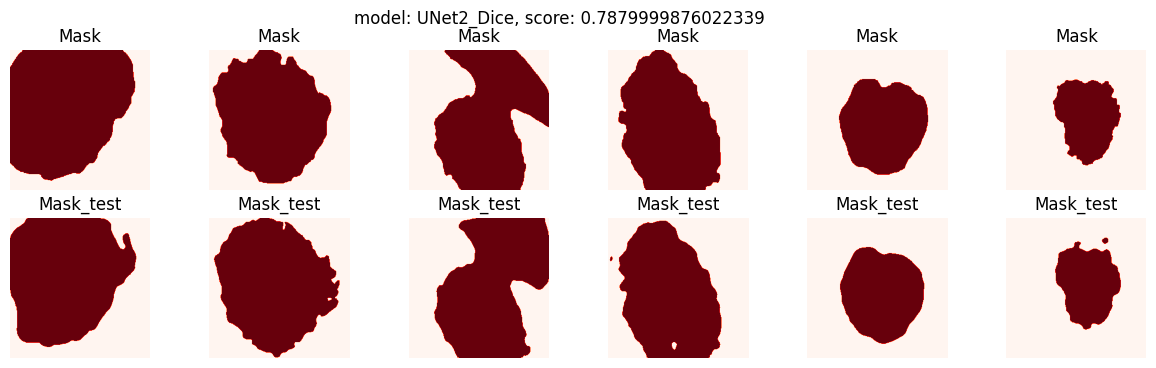

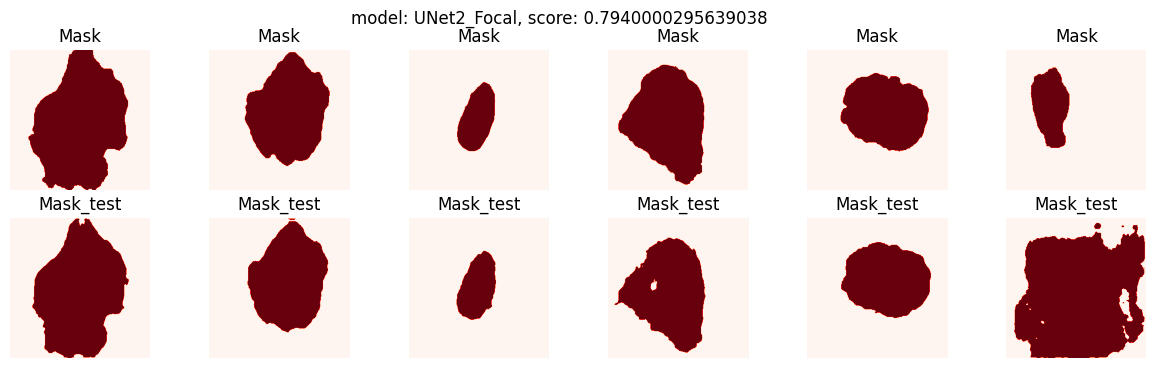

In [ ]:
for i in range(len(models_for_test)):
    predict(models_for_test[i][0], data_ts, models_for_test[i][1], models_for_test[i][2])

Посмотрим на итоговые результаты

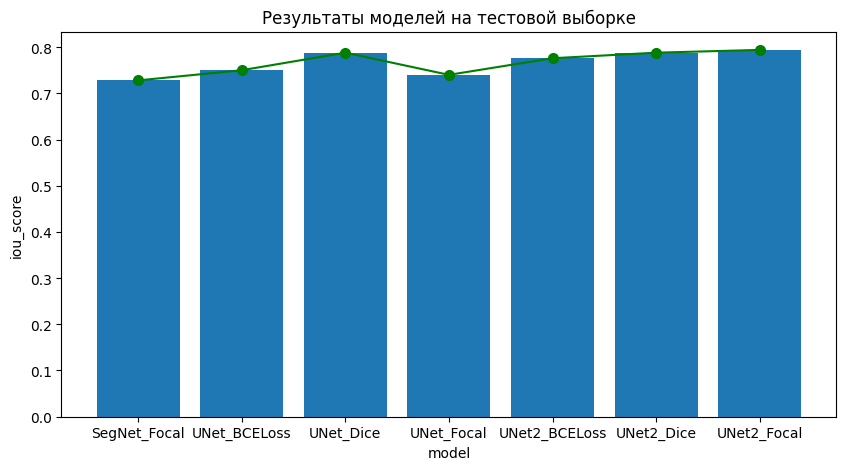

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(tests_results['model'], tests_results['iou_score'], width = 0.8)
plt.plot(tests_results['model'], tests_results['iou_score'], color='green', marker='o', markersize=7)

plt.title('Результаты моделей на тестовой выборке')
plt.ylabel('iou_score')
plt.xlabel('model')
plt.show()

In [ ]:
tests_results = tests_results.sort_values(by = ['iou_score'], ascending = False).reset_index()

In [ ]:
tests_results

model  iou_score
0    UNet2_Focal      0.794
1      UNet_Dice      0.788
2     UNet2_Dice      0.788
3  UNet2_BCELoss      0.776
4   UNet_BCELoss      0.750
5     UNet_Focal      0.740
6   SegNet_Focal      0.728

Мы видим, что наибольшее значение `iou_score` показала модель UNet2, обученная с помощью функции потерь Focal Loss

**Вывод по итогам работы**

В текущей работе мы провели сегментацию медицинских снимков. Были использованы три модели:
 - SegNet model
 - UNet model
 - UNet2 model (UNet model с изменением типа пуллинга, max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.)

Каждую модель мы обучали используя 4 лосс-функции:
 - BCE Loss
 - Dice Loss
 - Focal Loss
 - Boundary Loss

В результате для каждой функции были выбраны оптимальные параметры, а 7 лучших моделей были протестированны на тестовой выборке, где лучший результат показала модель UNet2, обученная с помощью функции потерь Focal Loss